In [7]:
from pathlib import Path
from natsort import natsorted
from pytorch_lightning.core.saving import *

import torch
from sklearn.manifold import TSNE

import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [8]:
from ml_lib.utils.tools import locate_and_import_class
_ROOT = Path()
out_path = 'output'
model_name = 'VisualTransformer'
exp_name = 'VT_2c7afd50e127f5a2339db0ddfd6bfd7c'
version = 'version_0'

In [9]:
plt.style.use('default')
sns.set_palette('Dark2')

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

Path('figures').mkdir(exist_ok=True)

In [15]:
def reconstruct_model_data_params(yaml_file_path: str):
    hparams_dict = load_hparams_from_yaml(yaml_file_path)

    # Try to get model_name and data_name from yaml:
    model_name = hparams_dict['model_name']
    data_name = hparams_dict['data_name']
    # Try to find the original model and data class by name:
    found_data_class = locate_and_import_class(data_name, 'datasets')
    found_model_class = locate_and_import_class(model_name, 'models')
    # Possible way of automatic loading args:
    # args = inspect.signature(found_data_class)
    # then access _parameter.ini and retrieve not set parameters

    hparams_dict.update(target_mel_length_in_seconds=1, num_worker=10, data_root='data')

    h_params = Namespace(**hparams_dict)

    # Let Datamodule pull what it wants
    datamodule = found_data_class.from_argparse_args(h_params)

    hparams_dict.update(in_shape=datamodule.shape, n_classes=datamodule.n_classes, variable_length=False)

    return datamodule, found_model_class, hparams_dict

def gather_predictions_and_labels(model, data_option):
        preds = list()
        labels = list()
        with torch.no_grad():
            for file_name, x, y in datamodule.datasets[data_option]:
                preds.append(model(x.unsqueeze(0)).main_out)
                labels.append(y)
        labels = np.stack(labels).squeeze()
        preds = torch.stack(preds).squeeze().cpu().numpy()
        return preds, labels

def build_tsne_dataframe(preds, labels):
    tsne = np.stack(TSNE().fit_transform(preds)).squeeze()
    tsne_dataframe = pd.DataFrame(data=tsne, columns=['x', 'y'])

    tsne_dataframe['labels'] = labels
    tsne_dataframe['labels'] = tsne_dataframe['labels'].map({val: key for key, val in datamodule.class_names.items()})
    return tsne_dataframe

def plot_scatterplot(data, option):
    p = sns.scatterplot(data=data, x='x', y='y', hue='labels', legend=True)
    p.set_title(f'TSNE - distribution of logits for {option}')
    plt.show()

In [11]:
exp_path = _ROOT / out_path / model_name / exp_name / version

checkpoint = natsorted(exp_path.glob('*.ckpt'))[-1]
hparams_yaml = next(exp_path.glob('*.yaml'))

datamodule, model_class, h_params = reconstruct_model_data_params(hparams_yaml.__str__())

model = model_class.load_from_checkpoint(checkpoint, return_logits=True, **h_params).eval()
datamodule.prepare_data()

test-dataset set up!
train-dataset set up!
devel-dataset set up!
Dataset CompareBase setup done.


{'test': <torch.utils.data.dataset.ConcatDataset at 0x7f3606daa5b0>,
 'train': <torch.utils.data.dataset.ConcatDataset at 0x7f360bda4f10>,
 'devel': <torch.utils.data.dataset.ConcatDataset at 0x7f359fd8deb0>}

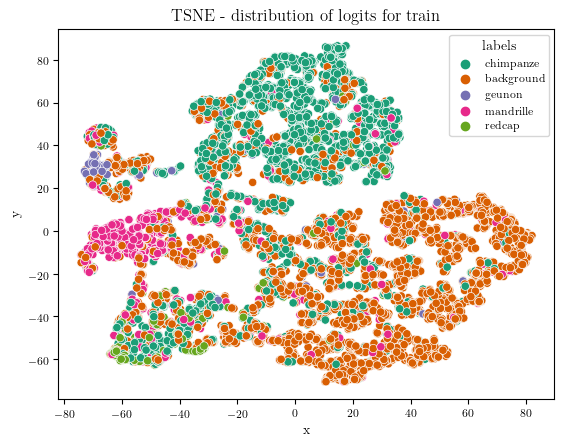

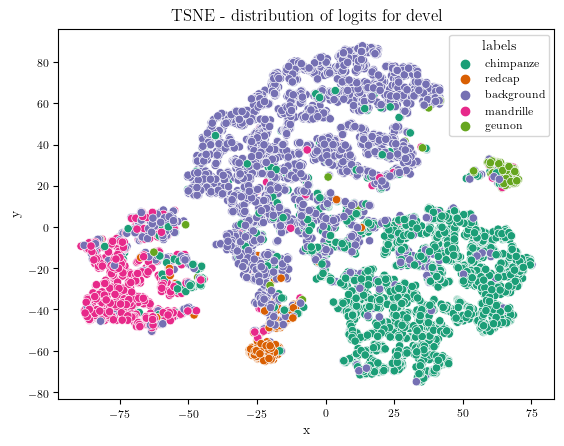

In [16]:
for data_option in ['train', 'devel']:
    predictions, labels_y = gather_predictions_and_labels(model, data_option)
    tsne_dataframe = build_tsne_dataframe(predictions, labels_y)
    plot_scatterplot(tsne_dataframe, data_option)